Show the GPU:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun  4 08:23:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Load data from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Prepare the dateset:

In [0]:
import os
import scipy.io as scio
import random
import numpy as np
import matplotlib.pyplot as plt

In [0]:
if not os.path.exists('./DAE_img'):
    os.mkdir('./DAE_img')
if not os.path.exists('./filters'):
    os.mkdir('./filters')

data size: (184, 64)


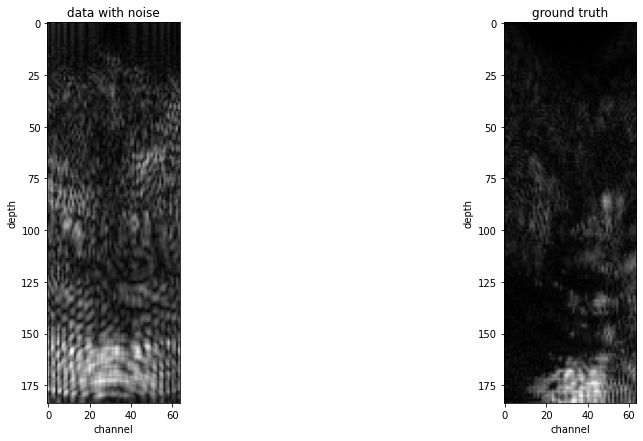

In [22]:
# show the test data and size
dataPath ='/content/drive/Shared drives/ECE228/final/dataset/ae/train1/'
def getTrainData(index):
    file_name = str(index)
    Img = scio.loadmat(dataPath + file_name + '.mat')
    dataN = Img['dataN']
    dataG = Img['dataG']
    where_are_nan_N = np.isnan(dataN)
    dataN[where_are_nan_N] = 0
    where_are_nan_G = np.isnan(dataG)
    dataN[where_are_nan_G] = 0
    dataN = min_max_normalization(dataN, 0, 1)
    dataG = min_max_normalization(dataG, 0, 1)
    return dataN, dataG

def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor
testdataN,testdataG = getTrainData(0)
print('data size:',testdataN.shape)
imgSizeY = testdataN.shape[0]
imgSizeX = testdataN.shape[1]
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(testdataN, 'gray')
plt.title('data with noise')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(1,2,2)
plt.imshow(testdataG, 'gray')
plt.title('ground truth')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()

In [27]:
# build dataset
filenum = len([lists for lists in os.listdir(dataPath) if os.path.isfile(os.path.join(dataPath, lists))])
inputSet = np.zeros([filenum,imgSizeY,imgSizeX])
labelSet = np.zeros([filenum,imgSizeY,imgSizeX])
for i in range(filenum):
  inputSet[i,:,:],labelSet[i,:,:] = getTrainData(i)
print(inputSet.shape)

(73, 184, 64)


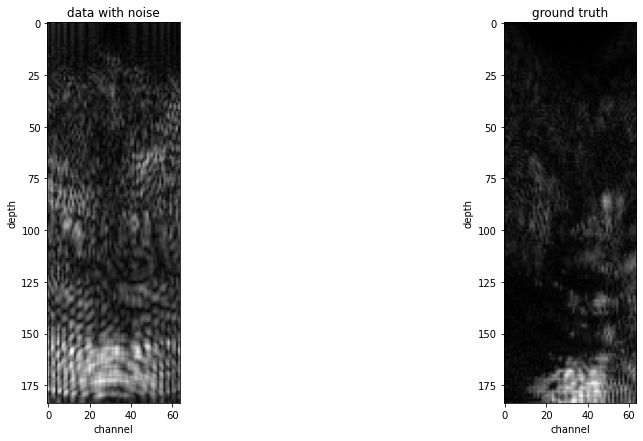

In [29]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(inputSet[0,:,:], 'gray')
plt.title('data with noise')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(1,2,2)
plt.imshow(labelSet[0,:,:], 'gray')
plt.title('ground truth')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()
np.save("inputSet1.npy", inputSet)
np.save("labelSet1.npy", labelSet)

In [30]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0


In [122]:
# Create Denosing Autoencoder
dropoutRate = 0.2
autoencoderDenosing = tf.keras.models.Sequential([
  keras.layers.Input(shape=(184,64, 1)),
    
  keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same',kernel_initializer='random_normal'),
  keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu', padding='same',kernel_initializer='random_normal'),
  keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(128 , (3, 3), activation='relu',padding='same',kernel_initializer='random_normal'),
  keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(128 , (3, 3), activation='relu',padding='same',kernel_initializer='random_normal'),
  keras.layers.UpSampling2D((2, 2)),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu', padding='same',kernel_initializer='random_normal'),
  keras.layers.UpSampling2D((2, 2)),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(32 , (3, 3), activation='relu',padding='same',kernel_initializer='random_normal'),
  keras.layers.UpSampling2D((2, 2)),
  keras.layers.Dropout(dropoutRate),

  keras.layers.Conv2D(1 , (3, 3), activation='relu',padding='same',kernel_initializer='random_normal'),
    
])
print(autoencoderDenosing.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 184, 64, 32)       320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 92, 32, 32)        0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 92, 32, 32)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 92, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 46, 16, 64)        0         
_________________________________________________________________
dropout_122 (Dropout)        (None, 46, 16, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 46, 16, 128)     

In [123]:
# data reshape (data the has already been normalized)
inputSet_reshape = inputSet.reshape(inputSet.shape[0],inputSet.shape[1],inputSet.shape[2],1)
labelSet_reshape = labelSet.reshape(labelSet.shape[0],labelSet.shape[1],labelSet.shape[2],1)

ranDataIndex = [i for i in range(len(inputSet_reshape))] 
random.Random(1).shuffle(ranDataIndex)
inputSet_reshape_ran = inputSet_reshape[ranDataIndex]
labelSet_reshape_ran = labelSet_reshape[ranDataIndex]

x_test = inputSet_reshape_ran[:2,:,:,:]
y_test = labelSet_reshape_ran[:2,:,:,:]

x_train = inputSet_reshape_ran[2:,:,:,:]
y_train = labelSet_reshape_ran[2:,:,:,:]
print(x_train.shape)

(71, 184, 64, 1)


In [127]:
autoencoderDenosing.compile(loss='mse', optimizer='adam')
history_conv_Denosing = autoencoderDenosing.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=25, shuffle=True)

Epoch 1/10
3/3 [==============================] - 0s 53ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 2/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 3/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 4/10
3/3 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 5/10
3/3 [==============================] - 0s 19ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 6/10
3/3 [==============================] - 0s 18ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 7/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 8/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 9/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 10/10
3/3 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0061


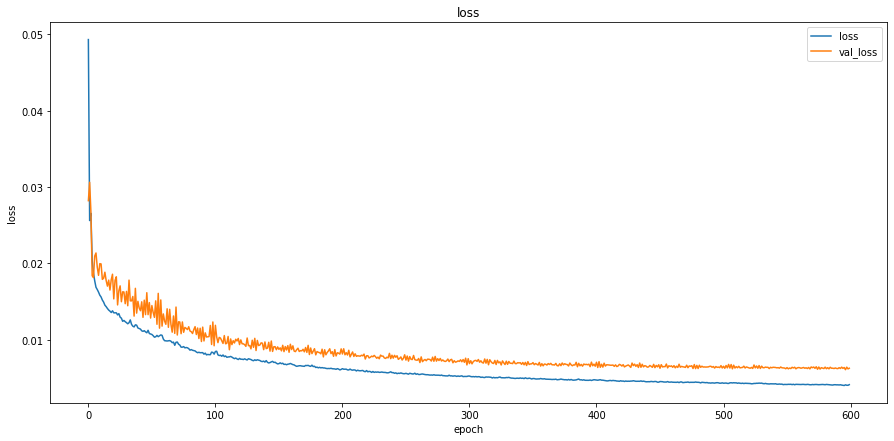

In [125]:
# Plot loss versus epoch.
plt.figure(figsize=(15,7))
plt.plot(history_conv_Denosing.history['loss'],label='loss')
plt.plot(history_conv_Denosing.history['val_loss'],label='val_loss')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

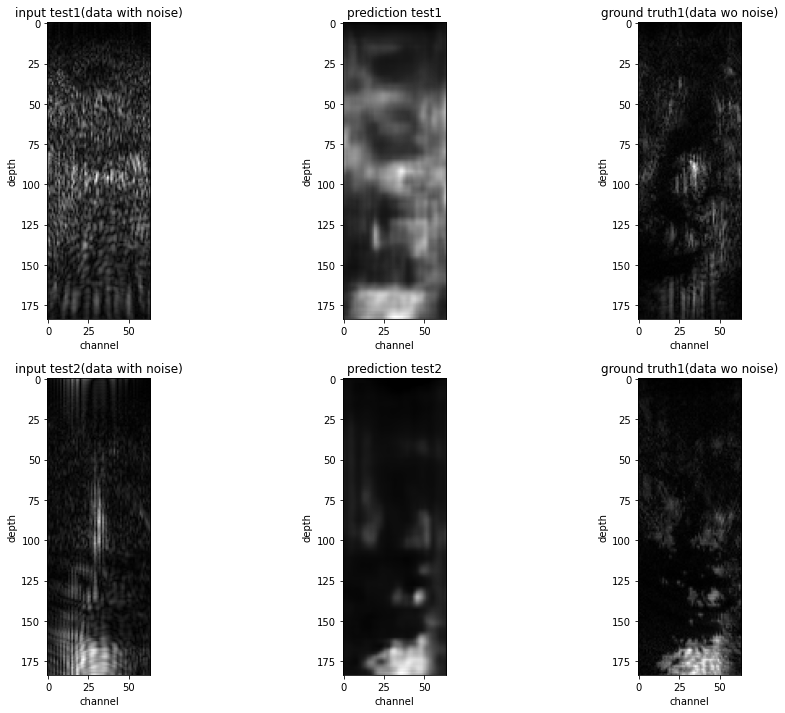

In [126]:
y_pred = autoencoderDenosing.predict(x_test)

plt.figure(figsize=(15,12))
plt.subplot(2,3,1)
plt.imshow(x_test[0,:,:,0], 'gray')
plt.title('input test1(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,2)
plt.imshow(y_pred[0,:,:,0], 'gray')
plt.title('prediction test1')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,3)
plt.imshow(y_test[0,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,4)
plt.imshow(x_test[1,:,:,0], 'gray')
plt.title('input test2(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,5)
plt.imshow(y_pred[1,:,:,0], 'gray')
plt.title('prediction test2')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,6)
plt.imshow(y_test[1,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()


In [150]:
#try u-net
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#input_img = Input((imgSizeY, imgSizeX, 1), name='img')
input_img = Input((176, 64, 1), name='img')
unet = get_unet(input_img)
unet.compile(loss='mse', optimizer='adam')
print(unet.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 176, 64, 1)   0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 176, 64, 16)  160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 176, 64, 16)  64          conv2d_107[0][0]                 
__________________________________________________________________________________________________
activation_102 (Activation)     (None, 176, 64, 16)  0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

In [0]:
x_train_unet = x_train[:,4:-4,:,:]
y_train_unet = y_train[:,4:-4,:,:]
x_test_unet = x_test[:,4:-4,:,:]
y_test_unet = y_test[:,4:-4,:,:]

Train on 56 samples, validate on 15 samples
Epoch 1/300
56/56 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.1832

Epoch 00001: val_loss improved from inf to 0.18316, saving model to model-tgs-salt.h5
Epoch 2/300
56/56 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.1768

Epoch 00002: val_loss improved from 0.18316 to 0.17683, saving model to model-tgs-salt.h5
Epoch 3/300
56/56 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.1704

Epoch 00003: val_loss improved from 0.17683 to 0.17040, saving model to model-tgs-salt.h5
Epoch 4/300
56/56 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.1645

Epoch 00004: val_loss improved from 0.17040 to 0.16446, saving model to model-tgs-salt.h5
Epoch 5/300
56/56 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.1592

Epoch 00005: val_loss improved from 0.16446 to 0.15918, saving model to model-tgs-salt.h5
Epoch 6/30

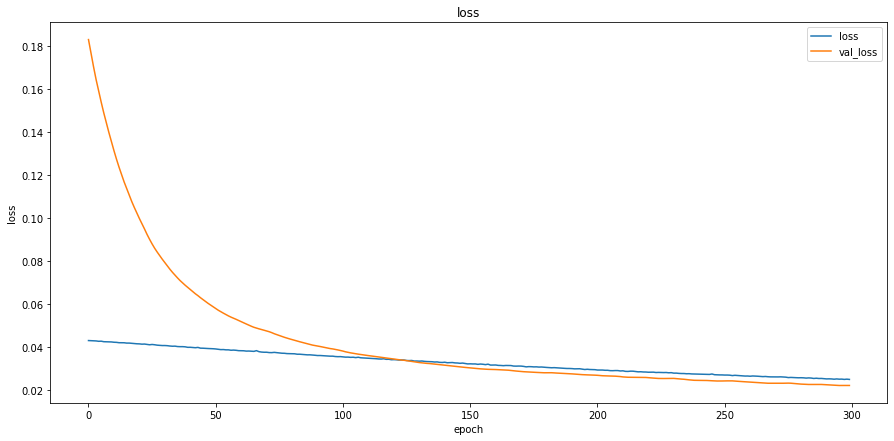

In [155]:
# callback for dynamic learning rate
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.001, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history_conv_unet = unet.fit(x_train_unet, y_train_unet, callbacks=callbacks, validation_split=0.2, epochs=300, batch_size=25, shuffle=True)

# Plot loss versus epoch.
plt.figure(figsize=(15,7))
plt.plot(history_conv_unet.history['loss'],label='loss')
plt.plot(history_conv_unet.history['val_loss'],label='val_loss')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

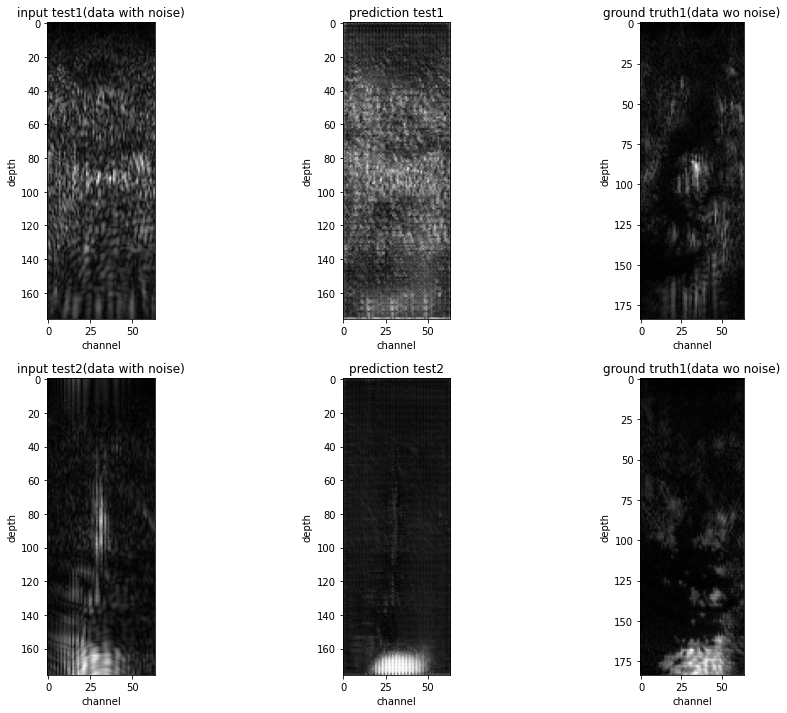

In [156]:
y_pred_unet = unet.predict(x_test_unet)

plt.figure(figsize=(15,12))
plt.subplot(2,3,1)
plt.imshow(x_test_unet[0,:,:,0], 'gray')
plt.title('input test1(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,2)
plt.imshow(y_pred_unet[0,:,:,0], 'gray')
plt.title('prediction test1')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,3)
plt.imshow(y_test[0,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,4)
plt.imshow(x_test_unet[1,:,:,0], 'gray')
plt.title('input test2(data with noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,5)
plt.imshow(y_pred_unet[1,:,:,0], 'gray')
plt.title('prediction test2')
plt.xlabel('channel')
plt.ylabel('depth')
plt.subplot(2,3,6)
plt.imshow(y_test[1,:,:,0], 'gray')
plt.title('ground truth1(data wo noise)')
plt.xlabel('channel')
plt.ylabel('depth')
plt.show()
